<a href="https://colab.research.google.com/github/princello/TCR-FOLD/blob/main/AlphaFold2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

##ColabFold v1.5.5: AlphaFold2 using MMseqs2

Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5).

Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb), [v1.5.2](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.2/AlphaFold2.ipynb), [v1.5.3-patch](https://colab.research.google.com/github/sokrypton/ColabFold/blob/56c72044c7d51a311ca99b953a71e552fdc042e1/AlphaFold2.ipynb)

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

In [2]:
#@title Input multiple protein sequences, then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
    return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

# Define multiple TCR-pMHC complex sequences
query_sequences = [
    "GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQ:LLFGYPVYV:EVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPELIMSIYSNGDKEDGRFTAQLNKASQYVSLLIRDSQPSDSATYLCAVTTDSWGKLQFGAGTQVVVTP:GVTQTPKFQVLKTGQSMTLQCAQDMNHEYMSWYRQDPGMGLRLIHYSVGAGITDQGEVPNGYNVSRSTTEDFPLRLLSAAPSQTSVYFCASRPGLAGGRPEQYFGPGTRLTVT",
    "GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQIFKTNTQTYRESLRNLRGYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQRRAYLEGLCVEWLRRYLENGKETLQ:LPEPLPQGQLTAY:QKVTQAQTEISVVEKEDVTLDCVYETRDTTYYLFWYKQPPSGELVFLIRRNSFDEQNEISGRYSWNFQKSTSSFNFTITASQVVDSAVYFCALSGFYNTDKLIFGTGTRLQVFP:GVTQTPKFQVLKTGQSMTLQCAQDMNHNSMYWYRQDPGMGLRLIYYSASEGTTDKGEVPNGYNVSRLNKREFSLRLESAAPSQTSVYFCASPGLAGEYEQYFGPGTRLTVT"
    ]

jobname_prefix = "TCR_pMHC_batch"  # Base job name
num_relax = "1"  #@param [0, 1, 5]
template_mode = "pdb100"  #@param ["none", "pdb100","custom"]
use_amber = True

# Create a directory for batch processing
batch_dir = "batch_results"
os.makedirs(batch_dir, exist_ok=True)

# Process each query sequence
batch_csv_path = os.path.join(batch_dir, "batch_queries.csv")
with open(batch_csv_path, "w") as batch_file:
    batch_file.write("id,sequence\n")  # Write CSV header

    for i, query_sequence in enumerate(query_sequences):
        jobname = f"{jobname_prefix}_{i}"
        query_sequence = "".join(query_sequence.split())  # Remove whitespace
        jobname = add_hash(jobname, query_sequence)

        # Save each sequence in the batch CSV
        batch_file.write(f"{jobname},{query_sequence}\n")

        print(f"Added job: {jobname}")
        print(f"Sequence length: {len(query_sequence.replace(':', ''))}")

print(f"Batch CSV saved at: {batch_csv_path}")


Added job: TCR_pMHC_batch_0_5600c
Sequence length: 411
Added job: TCR_pMHC_batch_1_416b8
Sequence length: 418
Batch CSV saved at: batch_results/batch_queries.csv


In [4]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = True
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.0.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=8.0.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
installing conda...
installing hhsuite and amber...
CPU times: user 230 ms, sys: 38.3 ms, total: 268 ms
Wall time: 1min 26s


In [5]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [6]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.
calc_extra_ptm = False #@param {type:"boolean"}
#@markdown - return pairwise chain iptm/actifptm

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 4 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = True #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

You are logged into Google Drive and are good to go!


2025-02-12 20:12:22,947 Running on GPU
2025-02-12 20:12:22,951 Found 9 citations for tools or databases
2025-02-12 20:12:22,951 Query 1/2: TCR_pMHC_batch_0_5600c (length 411)


COMPLETE: 100%|██████████| 600/600 [elapsed: 00:01 remaining: 00:00]


2025-02-12 20:12:46,753 Sequence 0 found templates: ['6rpb_K', '5jzi_F', '5e6i_I', '5hhm_F', '5e9d_F', '5iro_M', '7rk7_A', '5iro_A', '1b0r_A', '5jzi_A', '3rew_D', '7rtr_A', '5iro_Q', '5iro_E', '4eup_D', '7n6e_A', '6rpb_P', '6rpb_A', '1jf1_A', '4eup_A']
2025-02-12 20:12:46,754 Sequence 1 found no templates
2025-02-12 20:12:59,582 Sequence 2 found templates: ['4eup_I', '7pdx_CCC', '1ao7_D', '4zdh_A', '7qpj_A', '1qrn_D', '3qh3_C', '3h9s_D', '6uz1_D', '6uon_I', '6rp9_D', '6uon_G', '7ams_A', '4grm_A', '6vma_D', '5nmg_I', '5hyj_D', '5e9d_I', '6vqo_D', '7na5_D']
2025-02-12 20:13:08,432 Sequence 3 found templates: ['1ao7_E', '6uz1_E', '3qfj_E', '1qsf_E', '1qrn_E', '3d39_E', '4ftv_E', '7amp_B', '3qh3_B', '5e9d_J', '7amr_B', '7ams_B', '4grm_D', '1bd2_E', '4grm_B', '3qh3_D', '6zkz_E', '7q9b_JJJ', '4onh_B', '6vrm_E']


COMPLETE: 100%|██████████| 600/600 [elapsed: 00:01 remaining: 00:00]


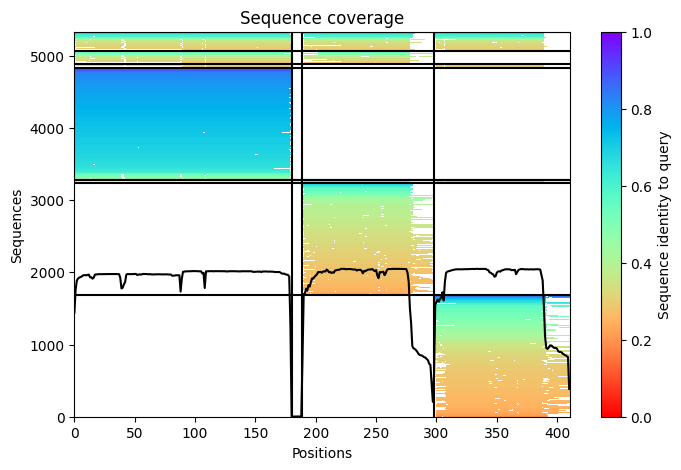

2025-02-12 20:14:39,091 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=94.6 pTM=0.887 ipTM=0.858
2025-02-12 20:14:44,111 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=96.2 pTM=0.92 ipTM=0.904 tol=0.627
2025-02-12 20:14:49,117 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=96.1 pTM=0.921 ipTM=0.905 tol=0.104
2025-02-12 20:14:49,118 alphafold2_multimer_v3_model_1_seed_000 took 88.9s (2 recycles)


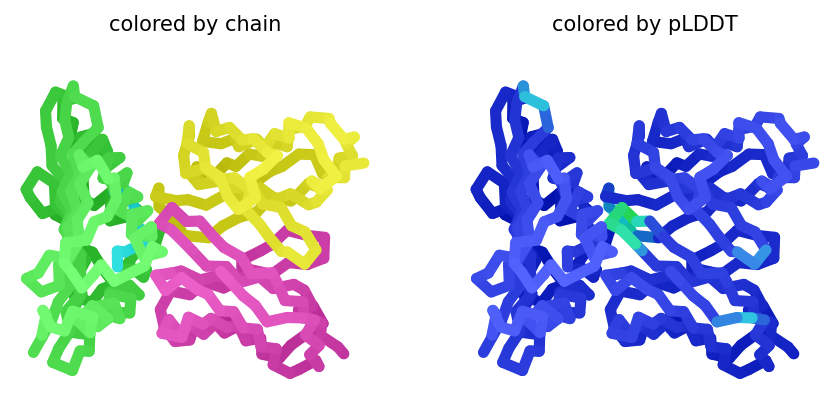

2025-02-12 20:14:54,431 alphafold2_multimer_v3_model_2_seed_000 recycle=0 pLDDT=94.1 pTM=0.884 ipTM=0.854
2025-02-12 20:14:59,389 alphafold2_multimer_v3_model_2_seed_000 recycle=1 pLDDT=94.8 pTM=0.902 ipTM=0.879 tol=0.467
2025-02-12 20:14:59,391 alphafold2_multimer_v3_model_2_seed_000 took 9.9s (1 recycles)


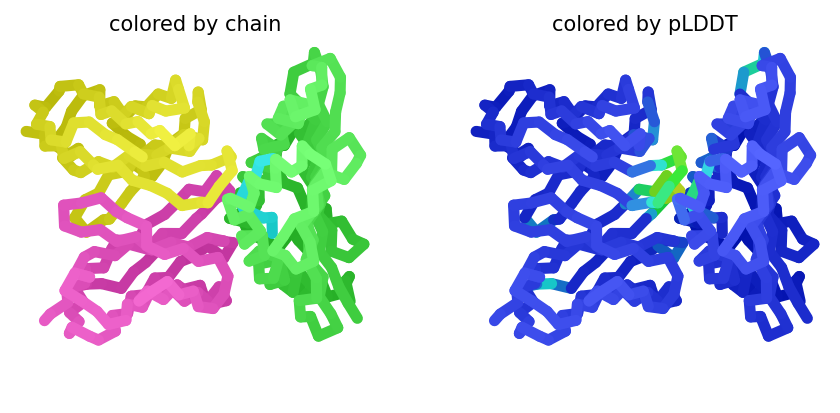

2025-02-12 20:15:04,663 alphafold2_multimer_v3_model_3_seed_000 recycle=0 pLDDT=93.2 pTM=0.841 ipTM=0.797
2025-02-12 20:15:09,582 alphafold2_multimer_v3_model_3_seed_000 recycle=1 pLDDT=93.6 pTM=0.863 ipTM=0.827 tol=0.448
2025-02-12 20:15:09,583 alphafold2_multimer_v3_model_3_seed_000 took 9.8s (1 recycles)


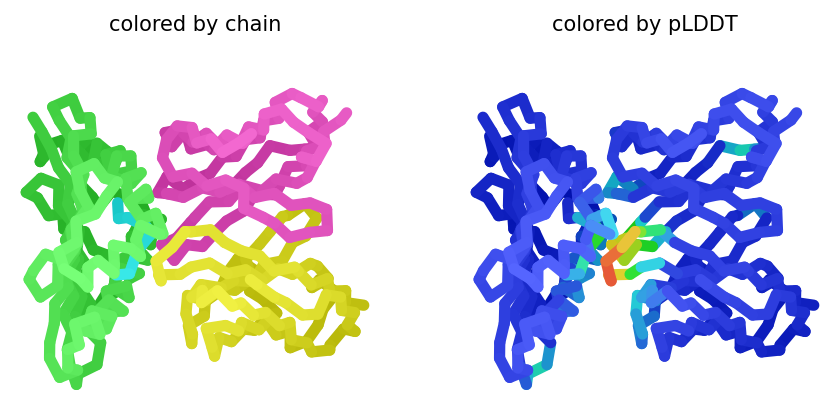

2025-02-12 20:15:14,899 alphafold2_multimer_v3_model_4_seed_000 recycle=0 pLDDT=94.6 pTM=0.898 ipTM=0.873
2025-02-12 20:15:19,837 alphafold2_multimer_v3_model_4_seed_000 recycle=1 pLDDT=94.4 pTM=0.896 ipTM=0.87 tol=0.47
2025-02-12 20:15:19,838 alphafold2_multimer_v3_model_4_seed_000 took 9.9s (1 recycles)


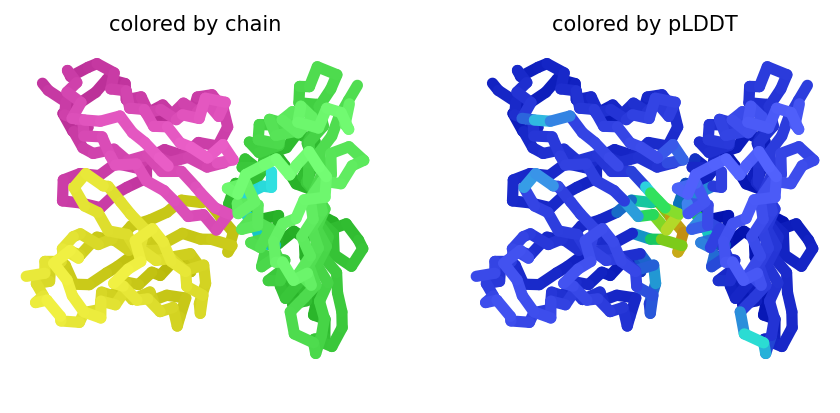

2025-02-12 20:15:25,113 alphafold2_multimer_v3_model_5_seed_000 recycle=0 pLDDT=93.5 pTM=0.872 ipTM=0.839
2025-02-12 20:15:30,008 alphafold2_multimer_v3_model_5_seed_000 recycle=1 pLDDT=93.2 pTM=0.859 ipTM=0.822 tol=0.522
2025-02-12 20:15:34,902 alphafold2_multimer_v3_model_5_seed_000 recycle=2 pLDDT=93.5 pTM=0.871 ipTM=0.838 tol=0.264
2025-02-12 20:15:34,904 alphafold2_multimer_v3_model_5_seed_000 took 14.7s (2 recycles)


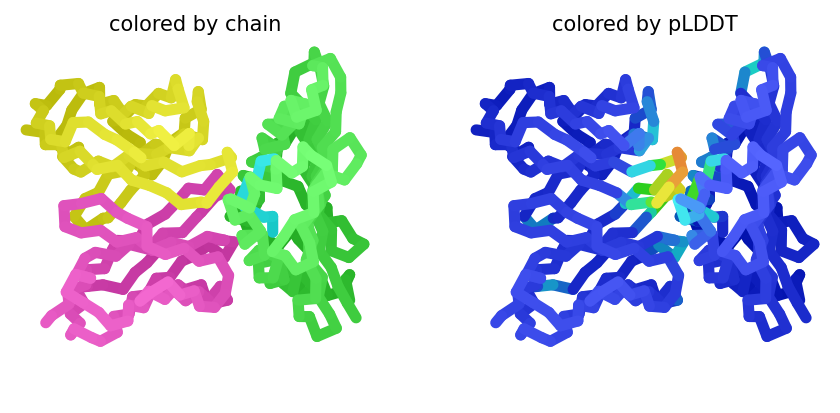

2025-02-12 20:15:40,196 alphafold2_multimer_v3_model_1_seed_001 recycle=0 pLDDT=93.8 pTM=0.874 ipTM=0.84
2025-02-12 20:15:45,096 alphafold2_multimer_v3_model_1_seed_001 recycle=1 pLDDT=93.5 pTM=0.855 ipTM=0.816 tol=0.655
2025-02-12 20:15:50,054 alphafold2_multimer_v3_model_1_seed_001 recycle=2 pLDDT=95.5 pTM=0.91 ipTM=0.89 tol=0.453
2025-02-12 20:15:50,056 alphafold2_multimer_v3_model_1_seed_001 took 14.8s (2 recycles)


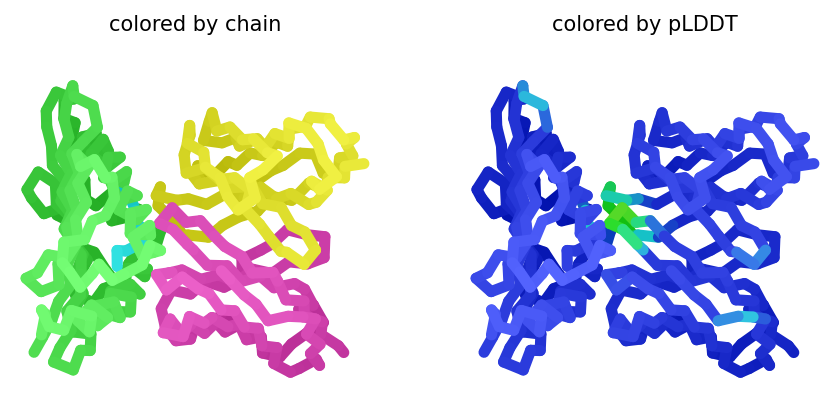

2025-02-12 20:15:55,355 alphafold2_multimer_v3_model_2_seed_001 recycle=0 pLDDT=94.1 pTM=0.89 ipTM=0.862
2025-02-12 20:16:00,296 alphafold2_multimer_v3_model_2_seed_001 recycle=1 pLDDT=94.6 pTM=0.899 ipTM=0.876 tol=0.501
2025-02-12 20:16:05,271 alphafold2_multimer_v3_model_2_seed_001 recycle=2 pLDDT=95.4 pTM=0.91 ipTM=0.89 tol=0.225
2025-02-12 20:16:05,273 alphafold2_multimer_v3_model_2_seed_001 took 14.9s (2 recycles)


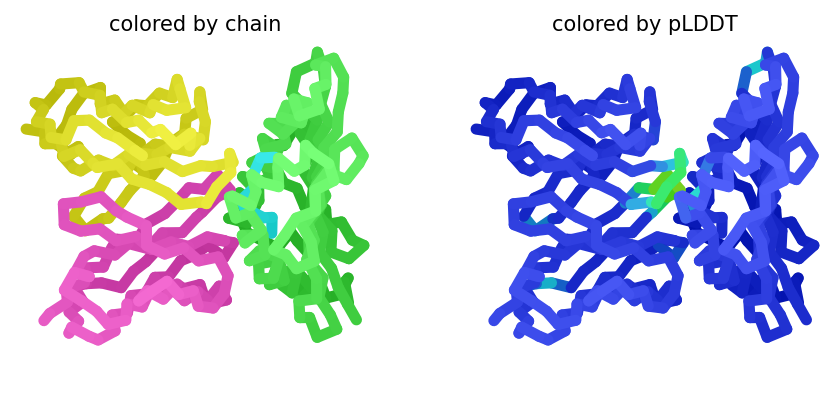

2025-02-12 20:16:10,553 alphafold2_multimer_v3_model_3_seed_001 recycle=0 pLDDT=92.8 pTM=0.824 ipTM=0.774
2025-02-12 20:16:15,456 alphafold2_multimer_v3_model_3_seed_001 recycle=1 pLDDT=93.2 pTM=0.849 ipTM=0.809 tol=0.544
2025-02-12 20:16:20,364 alphafold2_multimer_v3_model_3_seed_001 recycle=2 pLDDT=93.8 pTM=0.869 ipTM=0.835 tol=0.158
2025-02-12 20:16:20,365 alphafold2_multimer_v3_model_3_seed_001 took 14.7s (2 recycles)


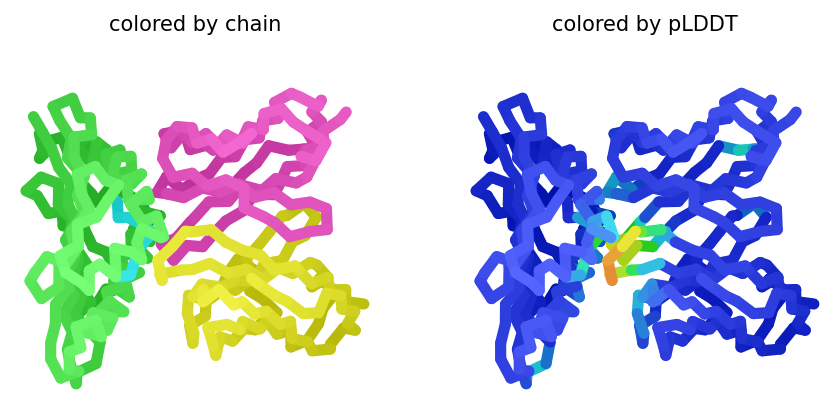

2025-02-12 20:16:25,660 alphafold2_multimer_v3_model_4_seed_001 recycle=0 pLDDT=94.1 pTM=0.882 ipTM=0.852
2025-02-12 20:16:30,592 alphafold2_multimer_v3_model_4_seed_001 recycle=1 pLDDT=94.5 pTM=0.894 ipTM=0.868 tol=0.475
2025-02-12 20:16:30,593 alphafold2_multimer_v3_model_4_seed_001 took 9.9s (1 recycles)


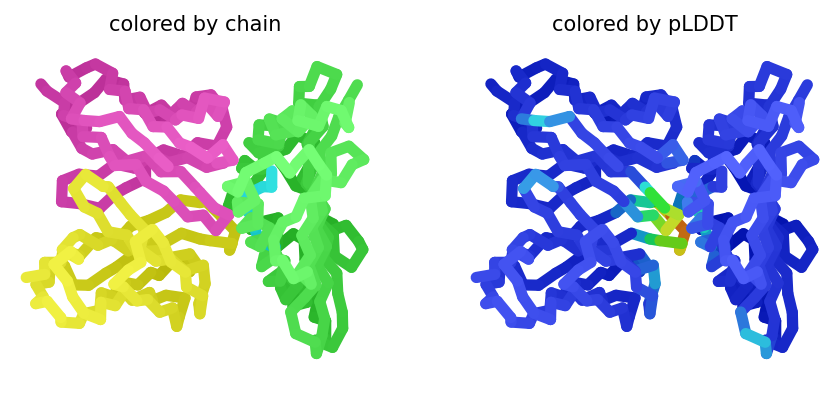

2025-02-12 20:16:35,873 alphafold2_multimer_v3_model_5_seed_001 recycle=0 pLDDT=93.4 pTM=0.878 ipTM=0.847
2025-02-12 20:16:40,763 alphafold2_multimer_v3_model_5_seed_001 recycle=1 pLDDT=93.1 pTM=0.856 ipTM=0.818 tol=0.621
2025-02-12 20:16:45,664 alphafold2_multimer_v3_model_5_seed_001 recycle=2 pLDDT=93.8 pTM=0.878 ipTM=0.848 tol=0.172
2025-02-12 20:16:45,665 alphafold2_multimer_v3_model_5_seed_001 took 14.7s (2 recycles)


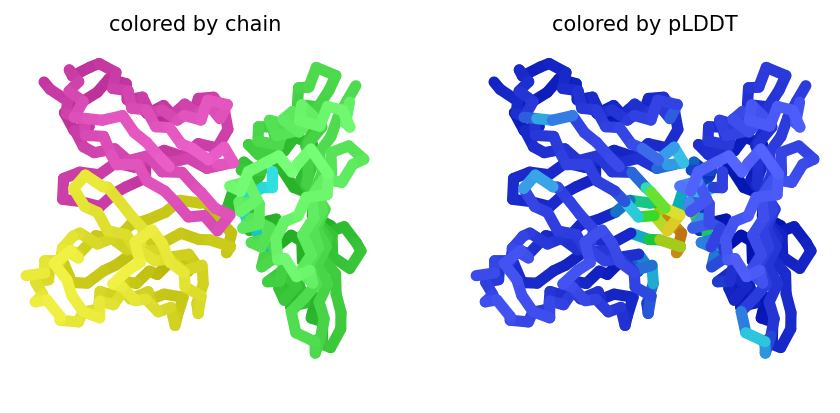

2025-02-12 20:16:50,941 alphafold2_multimer_v3_model_1_seed_002 recycle=0 pLDDT=92.8 pTM=0.828 ipTM=0.779
2025-02-12 20:16:55,848 alphafold2_multimer_v3_model_1_seed_002 recycle=1 pLDDT=93.5 pTM=0.855 ipTM=0.816 tol=0.475
2025-02-12 20:16:55,849 alphafold2_multimer_v3_model_1_seed_002 took 9.8s (1 recycles)


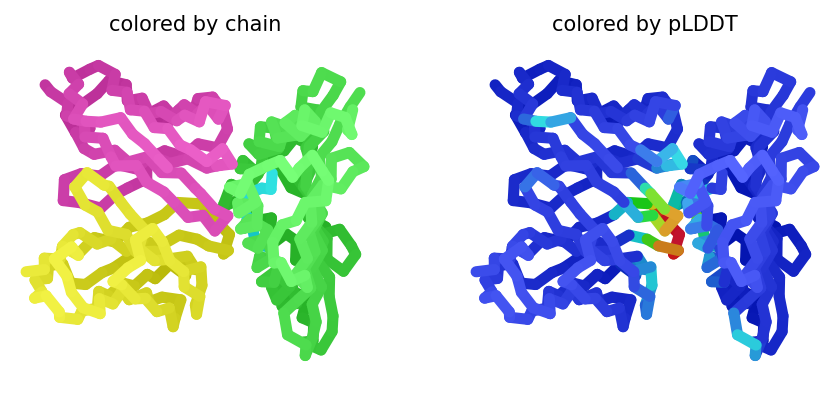

2025-02-12 20:17:01,118 alphafold2_multimer_v3_model_2_seed_002 recycle=0 pLDDT=93.3 pTM=0.854 ipTM=0.815
2025-02-12 20:17:06,035 alphafold2_multimer_v3_model_2_seed_002 recycle=1 pLDDT=94.2 pTM=0.887 ipTM=0.859 tol=0.398
2025-02-12 20:17:06,037 alphafold2_multimer_v3_model_2_seed_002 took 9.8s (1 recycles)


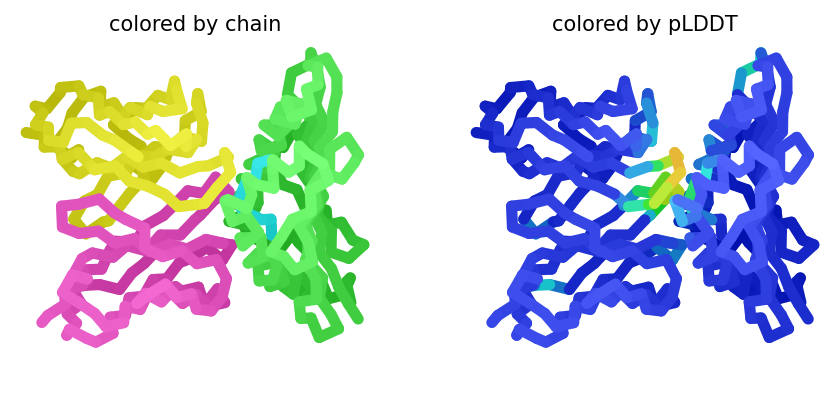

2025-02-12 20:17:11,320 alphafold2_multimer_v3_model_3_seed_002 recycle=0 pLDDT=93.1 pTM=0.844 ipTM=0.8
2025-02-12 20:17:16,230 alphafold2_multimer_v3_model_3_seed_002 recycle=1 pLDDT=93.5 pTM=0.862 ipTM=0.826 tol=0.514
2025-02-12 20:17:21,156 alphafold2_multimer_v3_model_3_seed_002 recycle=2 pLDDT=94.4 pTM=0.888 ipTM=0.861 tol=0.193
2025-02-12 20:17:21,157 alphafold2_multimer_v3_model_3_seed_002 took 14.8s (2 recycles)


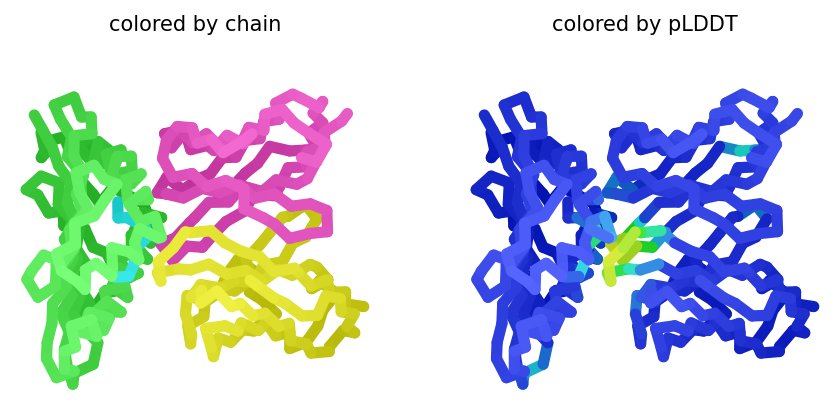

2025-02-12 20:17:26,476 alphafold2_multimer_v3_model_4_seed_002 recycle=0 pLDDT=94.9 pTM=0.899 ipTM=0.875
2025-02-12 20:17:31,517 alphafold2_multimer_v3_model_4_seed_002 recycle=1 pLDDT=96.5 pTM=0.927 ipTM=0.911 tol=0.46
2025-02-12 20:17:31,518 alphafold2_multimer_v3_model_4_seed_002 took 10.0s (1 recycles)


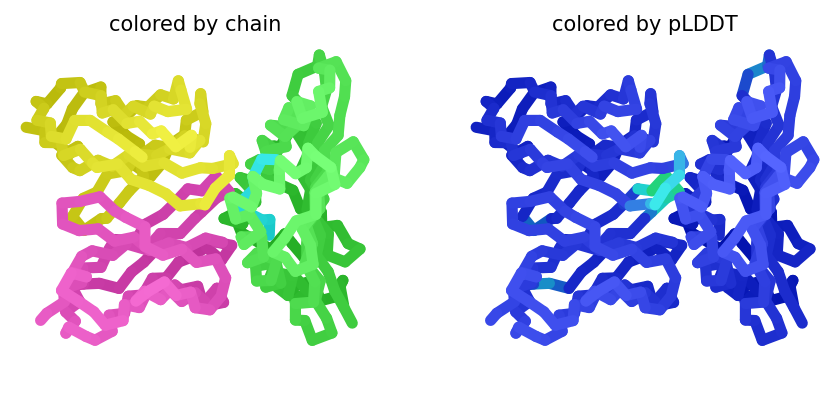

2025-02-12 20:17:36,813 alphafold2_multimer_v3_model_5_seed_002 recycle=0 pLDDT=93.2 pTM=0.878 ipTM=0.848
2025-02-12 20:17:41,707 alphafold2_multimer_v3_model_5_seed_002 recycle=1 pLDDT=93.2 pTM=0.849 ipTM=0.807 tol=0.766
2025-02-12 20:17:46,604 alphafold2_multimer_v3_model_5_seed_002 recycle=2 pLDDT=93.6 pTM=0.875 ipTM=0.842 tol=0.261
2025-02-12 20:17:46,605 alphafold2_multimer_v3_model_5_seed_002 took 14.7s (2 recycles)


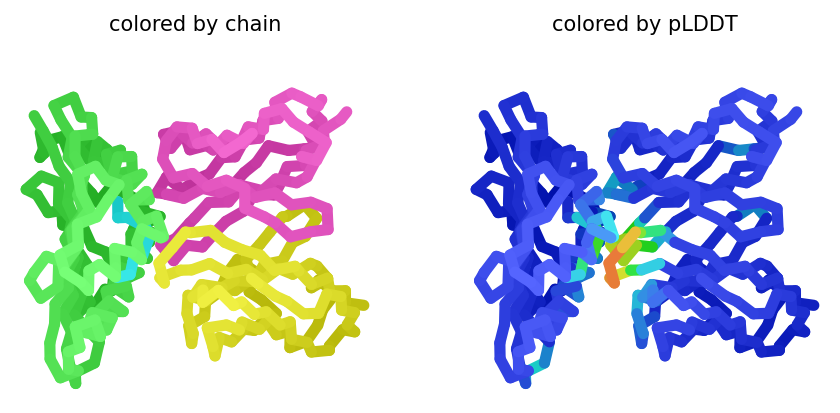

2025-02-12 20:17:51,879 alphafold2_multimer_v3_model_1_seed_003 recycle=0 pLDDT=93.4 pTM=0.854 ipTM=0.814
2025-02-12 20:17:56,800 alphafold2_multimer_v3_model_1_seed_003 recycle=1 pLDDT=94.4 pTM=0.889 ipTM=0.862 tol=0.507
2025-02-12 20:18:01,739 alphafold2_multimer_v3_model_1_seed_003 recycle=2 pLDDT=94.8 pTM=0.901 ipTM=0.878 tol=0.191
2025-02-12 20:18:01,741 alphafold2_multimer_v3_model_1_seed_003 took 14.8s (2 recycles)


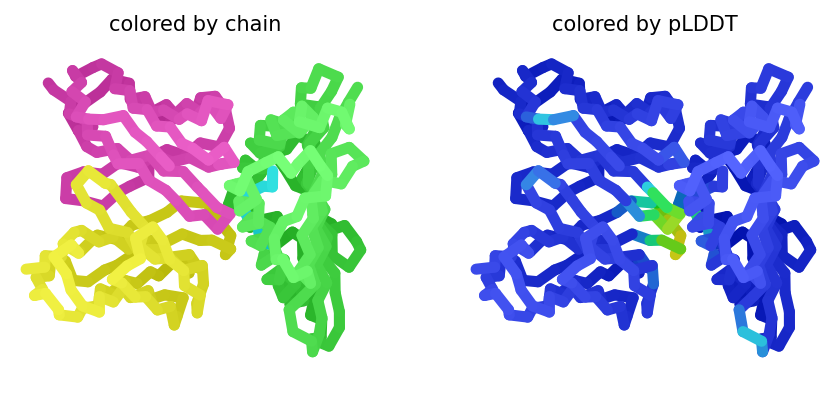

2025-02-12 20:18:07,015 alphafold2_multimer_v3_model_2_seed_003 recycle=0 pLDDT=93.9 pTM=0.869 ipTM=0.834
2025-02-12 20:18:11,952 alphafold2_multimer_v3_model_2_seed_003 recycle=1 pLDDT=94.6 pTM=0.898 ipTM=0.875 tol=0.357
2025-02-12 20:18:11,953 alphafold2_multimer_v3_model_2_seed_003 took 9.9s (1 recycles)


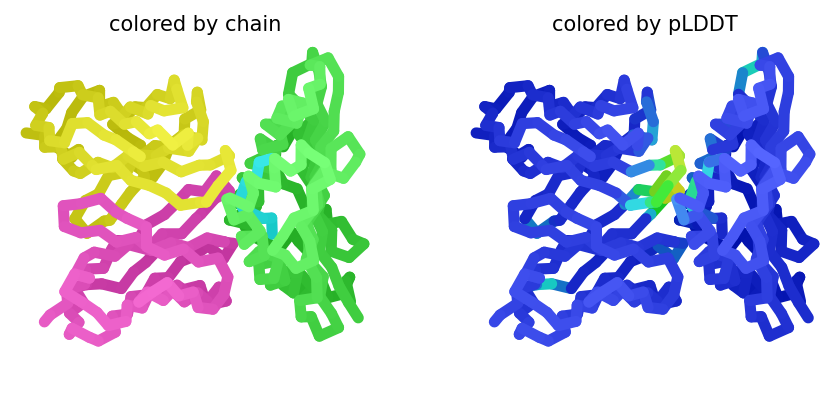

2025-02-12 20:18:17,217 alphafold2_multimer_v3_model_3_seed_003 recycle=0 pLDDT=92.2 pTM=0.776 ipTM=0.709
2025-02-12 20:18:22,118 alphafold2_multimer_v3_model_3_seed_003 recycle=1 pLDDT=93 pTM=0.822 ipTM=0.772 tol=0.686
2025-02-12 20:18:27,040 alphafold2_multimer_v3_model_3_seed_003 recycle=2 pLDDT=94.7 pTM=0.89 ipTM=0.864 tol=0.236
2025-02-12 20:18:27,042 alphafold2_multimer_v3_model_3_seed_003 took 14.7s (2 recycles)


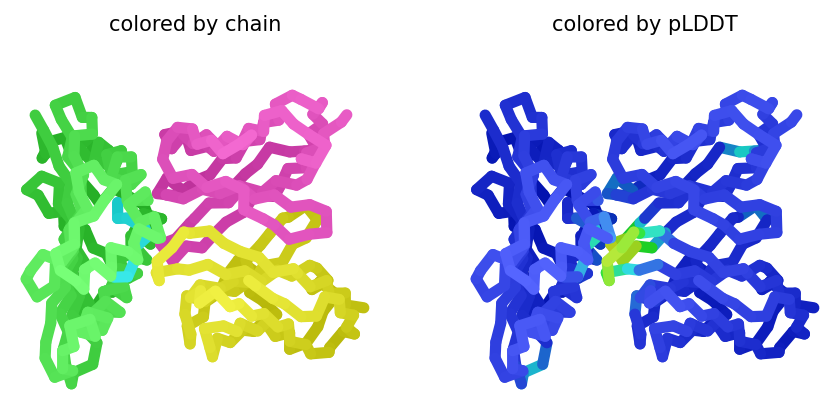

2025-02-12 20:18:32,364 alphafold2_multimer_v3_model_4_seed_003 recycle=0 pLDDT=94.9 pTM=0.899 ipTM=0.875
2025-02-12 20:18:37,402 alphafold2_multimer_v3_model_4_seed_003 recycle=1 pLDDT=96.4 pTM=0.927 ipTM=0.912 tol=0.392
2025-02-12 20:18:37,403 alphafold2_multimer_v3_model_4_seed_003 took 10.0s (1 recycles)


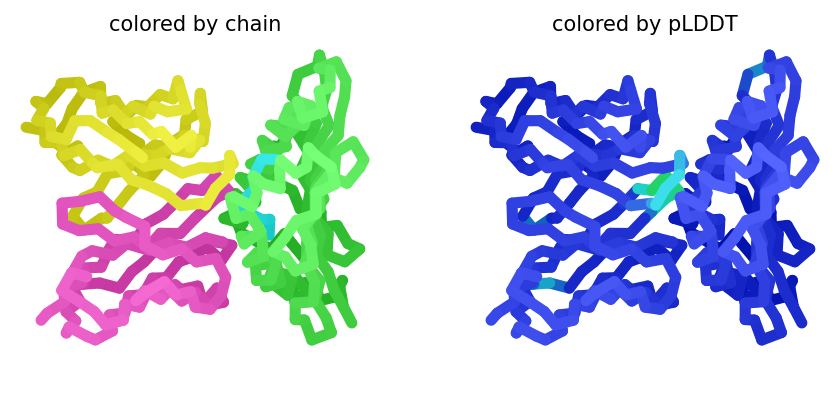

2025-02-12 20:18:42,658 alphafold2_multimer_v3_model_5_seed_003 recycle=0 pLDDT=92.9 pTM=0.854 ipTM=0.814
2025-02-12 20:18:47,553 alphafold2_multimer_v3_model_5_seed_003 recycle=1 pLDDT=93.4 pTM=0.863 ipTM=0.827 tol=0.682
2025-02-12 20:18:52,449 alphafold2_multimer_v3_model_5_seed_003 recycle=2 pLDDT=93.6 pTM=0.87 ipTM=0.836 tol=0.123
2025-02-12 20:18:52,450 alphafold2_multimer_v3_model_5_seed_003 took 14.7s (2 recycles)


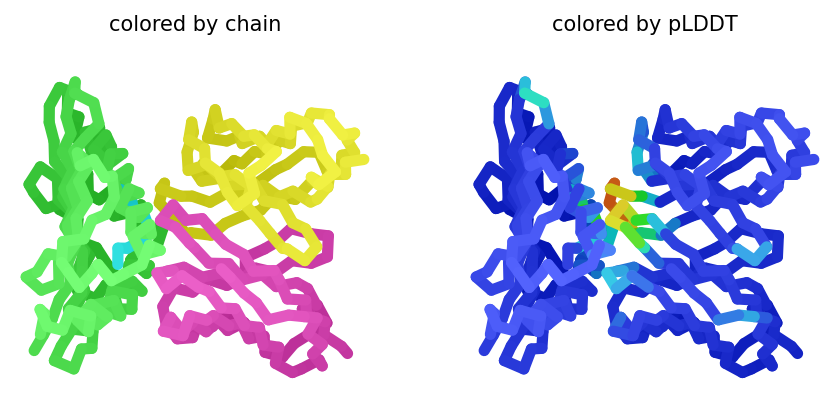

2025-02-12 20:18:52,800 reranking models by 'multimer' metric
2025-02-12 20:19:10,004 Relaxation took 17.2s
2025-02-12 20:19:10,005 rank_001_alphafold2_multimer_v3_model_4_seed_002 pLDDT=96.5 pTM=0.927 ipTM=0.911
2025-02-12 20:19:10,006 rank_002_alphafold2_multimer_v3_model_4_seed_003 pLDDT=96.4 pTM=0.927 ipTM=0.912
2025-02-12 20:19:10,006 rank_003_alphafold2_multimer_v3_model_1_seed_000 pLDDT=96.1 pTM=0.921 ipTM=0.905
2025-02-12 20:19:10,007 rank_004_alphafold2_multimer_v3_model_2_seed_001 pLDDT=95.4 pTM=0.91 ipTM=0.89
2025-02-12 20:19:10,007 rank_005_alphafold2_multimer_v3_model_1_seed_001 pLDDT=95.5 pTM=0.91 ipTM=0.89
2025-02-12 20:19:10,007 rank_006_alphafold2_multimer_v3_model_2_seed_000 pLDDT=94.8 pTM=0.902 ipTM=0.879
2025-02-12 20:19:10,008 rank_007_alphafold2_multimer_v3_model_1_seed_003 pLDDT=94.8 pTM=0.901 ipTM=0.878
2025-02-12 20:19:10,008 rank_008_alphafold2_multimer_v3_model_2_seed_003 pLDDT=94.6 pTM=0.898 ipTM=0.875
2025-02-12 20:19:10,009 rank_009_alphafold2_multimer_v3_

COMPLETE: 100%|██████████| 600/600 [elapsed: 00:01 remaining: 00:00]


2025-02-12 20:19:31,749 Sequence 0 found templates: ['6bj2_A', '3vfp_A', '4o2f_D', '1a1n_A', '7sif_A', '4lcy_F', '2axf_A', '7dc6_C', '4pra_A', '5xot_A', '7r80_C', '3vfo_A', '3vfn_A', '4mji_F', '5vgd_A', '3vfm_A', '3w39_D', '6vb4_A', '4i48_A', '3ln4_A']
2025-02-12 20:19:36,685 Sequence 1 found templates: ['1zhk_C', '1zhl_C', '2ak4_C', '2ak4_H', '2ak4_M', '2ak4_S', '3kww_C', '3kxf_Q', '3kxf_R', '3kxf_S', '3kxf_T', '3vfm_C', '3vfn_C', '3vfo_C', '3vfp_C', '4jrx_C', '4jry_C', '3vfs_C', '3vfu_C', '3vfw_C']
2025-02-12 20:19:49,928 Sequence 2 found templates: ['3kxf_M', '2ak4_D', '4jrx_D', '7t2d_I', '6bj2_D', '8es7_A', '7pb2_D', '7pb2_I', '4g9f_D', '5jhd_I', '5swz_D', '6xc9_D', '5jhd_D', '6xc9_I', '5yxn_A', '5sws_D', '5swz_I', '8gon_D', '6uk2_D', '5jzi_I']
2025-02-12 20:20:03,913 Sequence 3 found templates: ['1bd2_E', '1u3h_F', '2ak4_P', '4onh_B', '4z7w_F', '2z35_B', '4z7w_H', '6vrm_E', '3kxf_O', '4pjd_F', '4pjd_H', '2ak4_U', '5xot_E', '6bj3_H', '4pje_F', '4jrx_E', '8dv4_E', '7phr_B', '6cuh_B'

PENDING:   0%|          | 0/600 [elapsed: 00:00 remaining: ?]

2025-02-12 20:20:04,283 Sleeping for 5s. Reason: PENDING


RUNNING:   1%|          | 5/600 [elapsed: 00:05 remaining: 11:15]

2025-02-12 20:20:09,610 Sleeping for 10s. Reason: RUNNING


RUNNING:   2%|▎         | 15/600 [elapsed: 00:16 remaining: 10:19]

2025-02-12 20:20:19,936 Sleeping for 9s. Reason: RUNNING


RUNNING:   4%|▍         | 24/600 [elapsed: 00:25 remaining: 10:03]

2025-02-12 20:20:29,262 Sleeping for 6s. Reason: RUNNING


RUNNING:   5%|▌         | 30/600 [elapsed: 00:31 remaining: 09:59]

2025-02-12 20:20:35,620 Sleeping for 8s. Reason: RUNNING


RUNNING:   6%|▋         | 38/600 [elapsed: 00:40 remaining: 09:48]

2025-02-12 20:20:43,943 Sleeping for 8s. Reason: RUNNING


RUNNING:   8%|▊         | 46/600 [elapsed: 00:48 remaining: 09:38]

2025-02-12 20:20:52,265 Sleeping for 10s. Reason: RUNNING


COMPLETE: 100%|██████████| 600/600 [elapsed: 00:59 remaining: 00:00]


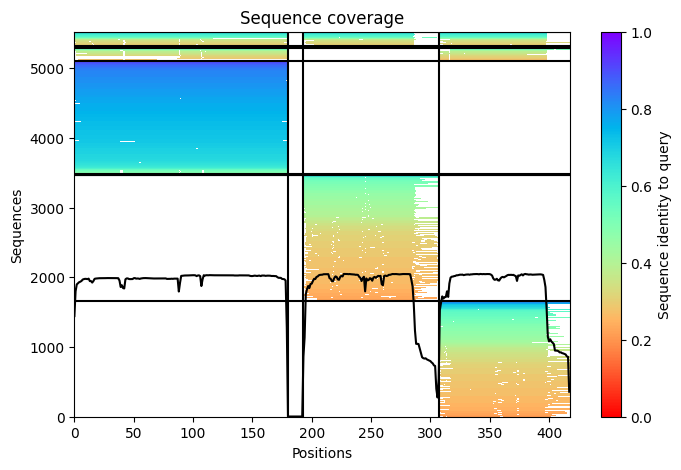

2025-02-12 20:22:19,048 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=93.7 pTM=0.802 ipTM=0.74
2025-02-12 20:22:24,199 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=95.8 pTM=0.894 ipTM=0.866 tol=1.57
2025-02-12 20:22:29,520 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=96.6 pTM=0.942 ipTM=0.927 tol=0.498
2025-02-12 20:22:29,522 alphafold2_multimer_v3_model_1_seed_000 took 84.1s (2 recycles)


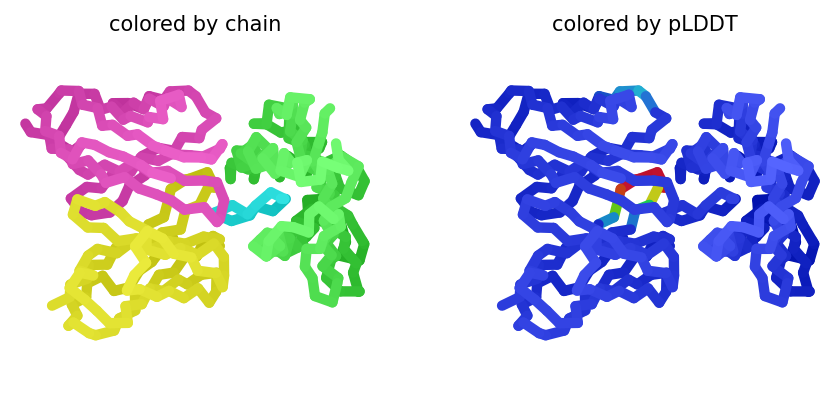

2025-02-12 20:22:34,978 alphafold2_multimer_v3_model_2_seed_000 recycle=0 pLDDT=92.1 pTM=0.718 ipTM=0.625
2025-02-12 20:22:40,144 alphafold2_multimer_v3_model_2_seed_000 recycle=1 pLDDT=95.6 pTM=0.896 ipTM=0.868 tol=1.62
2025-02-12 20:22:45,426 alphafold2_multimer_v3_model_2_seed_000 recycle=2 pLDDT=96.4 pTM=0.935 ipTM=0.914 tol=0.27
2025-02-12 20:22:45,427 alphafold2_multimer_v3_model_2_seed_000 took 15.5s (2 recycles)


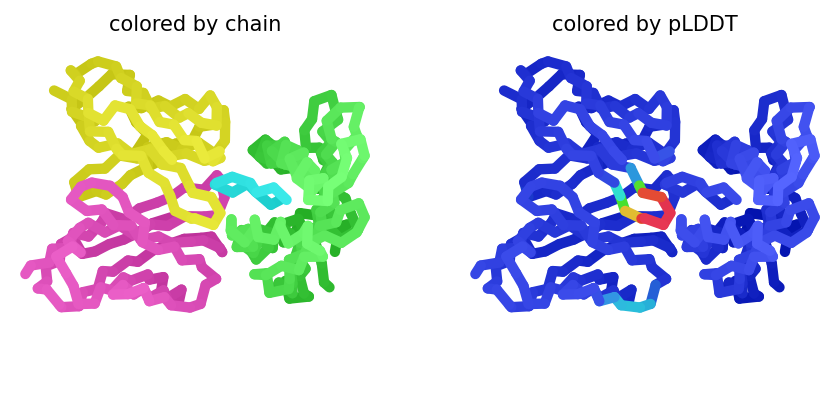

2025-02-12 20:22:50,928 alphafold2_multimer_v3_model_3_seed_000 recycle=0 pLDDT=94.5 pTM=0.88 ipTM=0.847
2025-02-12 20:22:56,070 alphafold2_multimer_v3_model_3_seed_000 recycle=1 pLDDT=95.1 pTM=0.872 ipTM=0.843 tol=1.43
2025-02-12 20:23:01,309 alphafold2_multimer_v3_model_3_seed_000 recycle=2 pLDDT=96.2 pTM=0.924 ipTM=0.902 tol=0.398
2025-02-12 20:23:01,310 alphafold2_multimer_v3_model_3_seed_000 took 15.5s (2 recycles)


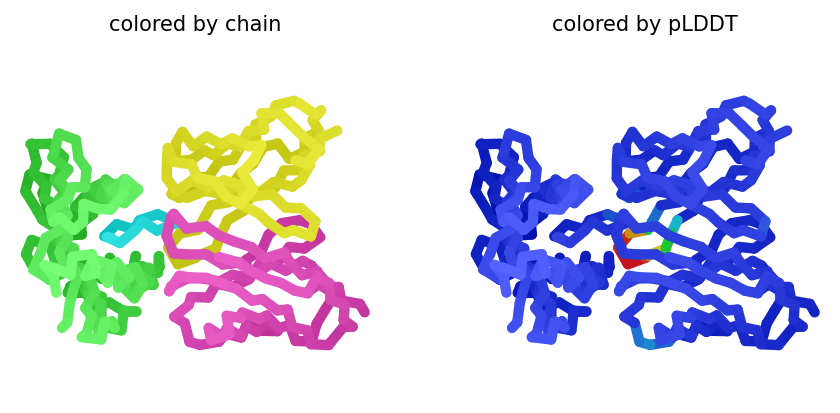

2025-02-12 20:23:06,762 alphafold2_multimer_v3_model_4_seed_000 recycle=0 pLDDT=91 pTM=0.642 ipTM=0.518
2025-02-12 20:23:12,020 alphafold2_multimer_v3_model_4_seed_000 recycle=1 pLDDT=96.6 pTM=0.927 ipTM=0.908 tol=1.29
2025-02-12 20:23:17,318 alphafold2_multimer_v3_model_4_seed_000 recycle=2 pLDDT=96.5 pTM=0.937 ipTM=0.914 tol=0.39
2025-02-12 20:23:17,319 alphafold2_multimer_v3_model_4_seed_000 took 15.6s (2 recycles)


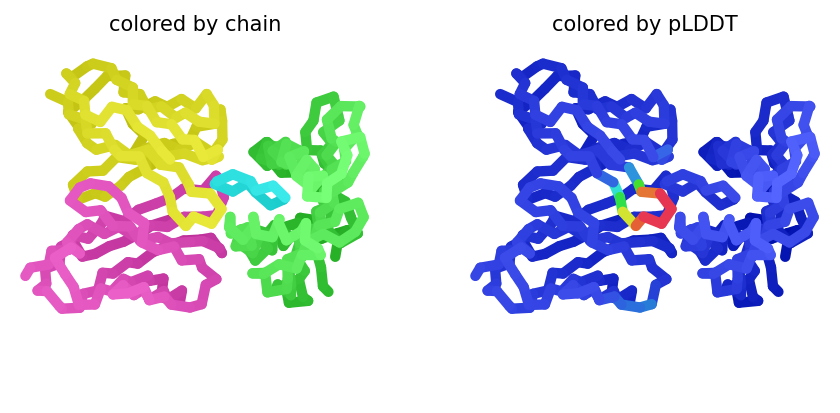

2025-02-12 20:23:22,793 alphafold2_multimer_v3_model_5_seed_000 recycle=0 pLDDT=94.4 pTM=0.858 ipTM=0.816
2025-02-12 20:23:28,022 alphafold2_multimer_v3_model_5_seed_000 recycle=1 pLDDT=96.2 pTM=0.92 ipTM=0.899 tol=0.721
2025-02-12 20:23:33,322 alphafold2_multimer_v3_model_5_seed_000 recycle=2 pLDDT=96.8 pTM=0.942 ipTM=0.922 tol=0.284
2025-02-12 20:23:33,323 alphafold2_multimer_v3_model_5_seed_000 took 15.7s (2 recycles)


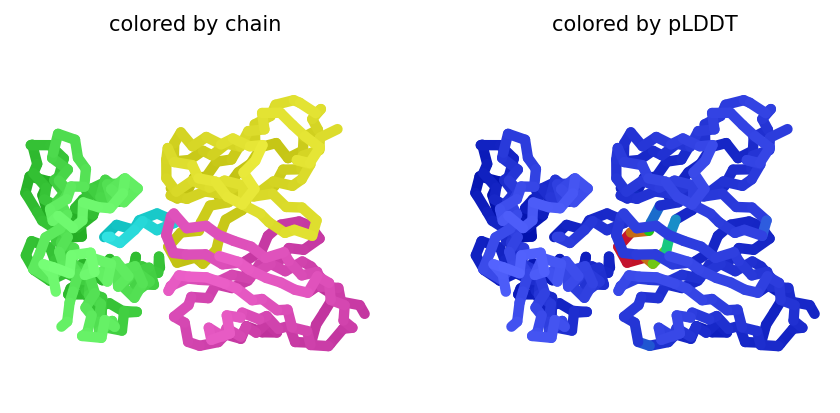

2025-02-12 20:23:38,816 alphafold2_multimer_v3_model_1_seed_001 recycle=0 pLDDT=94 pTM=0.813 ipTM=0.755
2025-02-12 20:23:43,957 alphafold2_multimer_v3_model_1_seed_001 recycle=1 pLDDT=95.6 pTM=0.876 ipTM=0.845 tol=1.7
2025-02-12 20:23:49,215 alphafold2_multimer_v3_model_1_seed_001 recycle=2 pLDDT=96.2 pTM=0.925 ipTM=0.906 tol=0.64
2025-02-12 20:23:54,530 alphafold2_multimer_v3_model_1_seed_001 recycle=3 pLDDT=96.8 pTM=0.944 ipTM=0.927 tol=0.276
2025-02-12 20:23:54,531 alphafold2_multimer_v3_model_1_seed_001 took 20.8s (3 recycles)


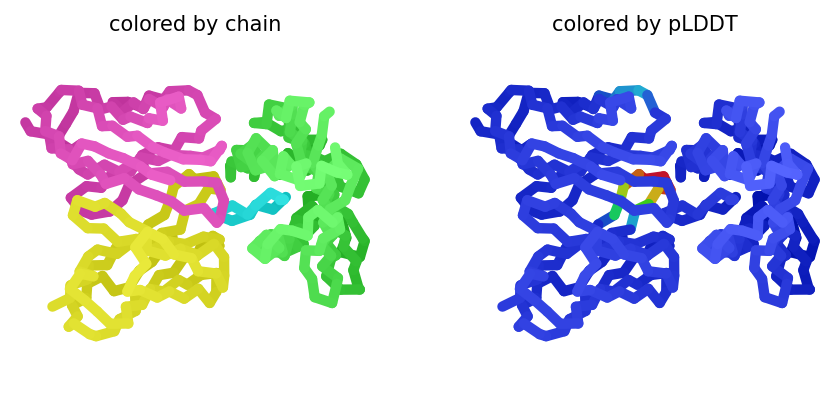

2025-02-12 20:23:59,992 alphafold2_multimer_v3_model_2_seed_001 recycle=0 pLDDT=92.6 pTM=0.79 ipTM=0.728
2025-02-12 20:24:05,105 alphafold2_multimer_v3_model_2_seed_001 recycle=1 pLDDT=94.8 pTM=0.849 ipTM=0.81 tol=1.84
2025-02-12 20:24:10,356 alphafold2_multimer_v3_model_2_seed_001 recycle=2 pLDDT=96.3 pTM=0.927 ipTM=0.901 tol=0.489
2025-02-12 20:24:10,357 alphafold2_multimer_v3_model_2_seed_001 took 15.5s (2 recycles)


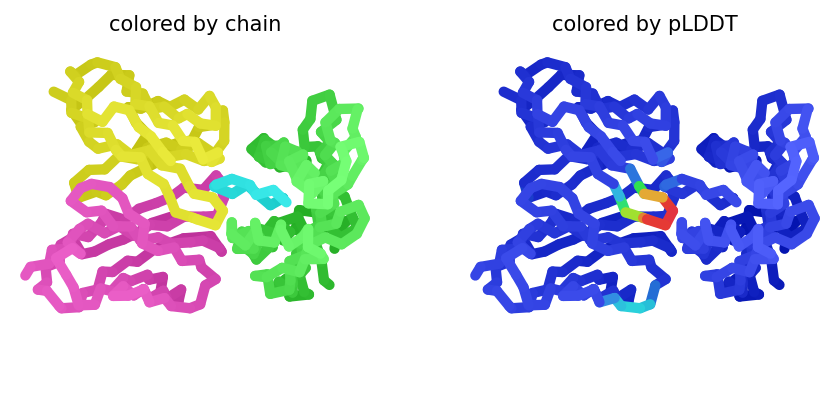

2025-02-12 20:24:15,853 alphafold2_multimer_v3_model_3_seed_001 recycle=0 pLDDT=94.7 pTM=0.882 ipTM=0.849
2025-02-12 20:24:21,060 alphafold2_multimer_v3_model_3_seed_001 recycle=1 pLDDT=95.7 pTM=0.904 ipTM=0.877 tol=1.13
2025-02-12 20:24:26,317 alphafold2_multimer_v3_model_3_seed_001 recycle=2 pLDDT=96.3 pTM=0.929 ipTM=0.91 tol=0.295
2025-02-12 20:24:26,318 alphafold2_multimer_v3_model_3_seed_001 took 15.6s (2 recycles)


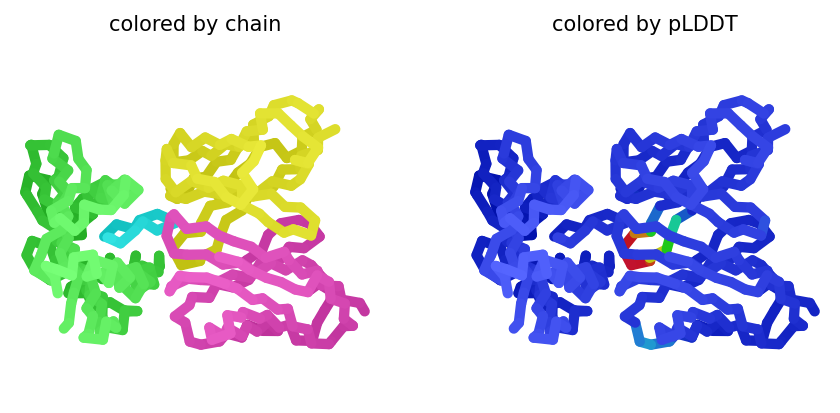

2025-02-12 20:24:31,825 alphafold2_multimer_v3_model_4_seed_001 recycle=0 pLDDT=94.3 pTM=0.855 ipTM=0.816
2025-02-12 20:24:36,938 alphafold2_multimer_v3_model_4_seed_001 recycle=1 pLDDT=95.1 pTM=0.868 ipTM=0.83 tol=2.14
2025-02-12 20:24:42,160 alphafold2_multimer_v3_model_4_seed_001 recycle=2 pLDDT=96.1 pTM=0.919 ipTM=0.899 tol=0.419
2025-02-12 20:24:42,161 alphafold2_multimer_v3_model_4_seed_001 took 15.5s (2 recycles)


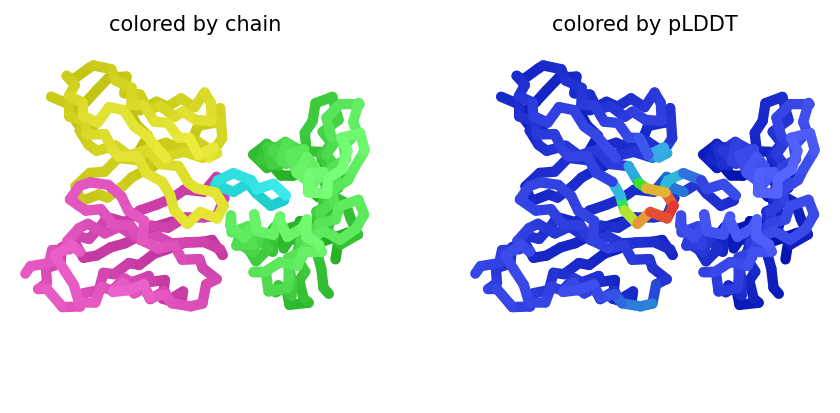

2025-02-12 20:24:47,633 alphafold2_multimer_v3_model_5_seed_001 recycle=0 pLDDT=94.3 pTM=0.851 ipTM=0.807
2025-02-12 20:24:52,882 alphafold2_multimer_v3_model_5_seed_001 recycle=1 pLDDT=96.4 pTM=0.924 ipTM=0.905 tol=0.721
2025-02-12 20:24:58,179 alphafold2_multimer_v3_model_5_seed_001 recycle=2 pLDDT=96.8 pTM=0.942 ipTM=0.922 tol=0.275
2025-02-12 20:24:58,180 alphafold2_multimer_v3_model_5_seed_001 took 15.7s (2 recycles)


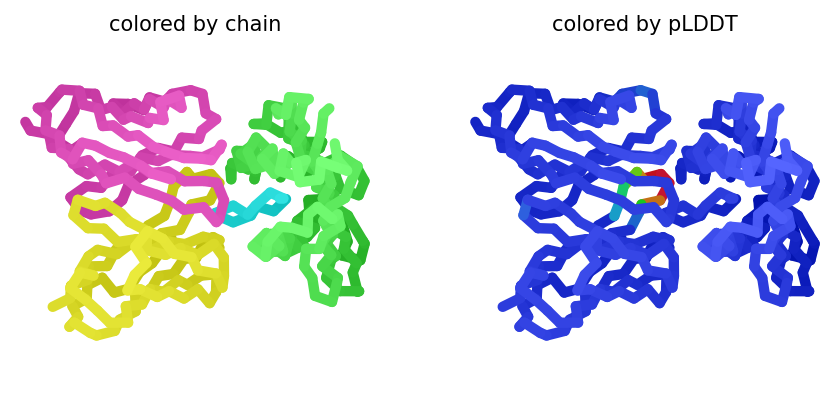

2025-02-12 20:25:03,680 alphafold2_multimer_v3_model_1_seed_002 recycle=0 pLDDT=94.6 pTM=0.868 ipTM=0.826
2025-02-12 20:25:08,825 alphafold2_multimer_v3_model_1_seed_002 recycle=1 pLDDT=95.6 pTM=0.88 ipTM=0.849 tol=1.89
2025-02-12 20:25:14,071 alphafold2_multimer_v3_model_1_seed_002 recycle=2 pLDDT=96.2 pTM=0.92 ipTM=0.905 tol=0.665
2025-02-12 20:25:19,392 alphafold2_multimer_v3_model_1_seed_002 recycle=3 pLDDT=96.6 pTM=0.943 ipTM=0.928 tol=0.311
2025-02-12 20:25:19,394 alphafold2_multimer_v3_model_1_seed_002 took 20.9s (3 recycles)


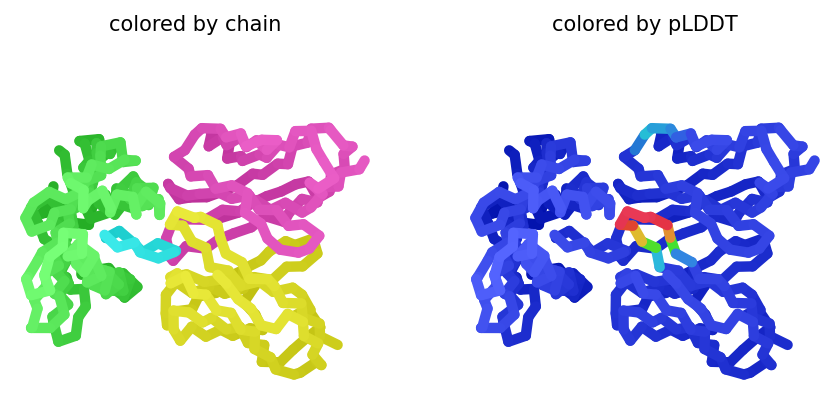

2025-02-12 20:25:24,867 alphafold2_multimer_v3_model_2_seed_002 recycle=0 pLDDT=91.7 pTM=0.864 ipTM=0.828
2025-02-12 20:25:30,040 alphafold2_multimer_v3_model_2_seed_002 recycle=1 pLDDT=95.8 pTM=0.892 ipTM=0.862 tol=2.07
2025-02-12 20:25:35,333 alphafold2_multimer_v3_model_2_seed_002 recycle=2 pLDDT=96.5 pTM=0.936 ipTM=0.919 tol=0.513
2025-02-12 20:25:40,621 alphafold2_multimer_v3_model_2_seed_002 recycle=3 pLDDT=96.7 pTM=0.941 ipTM=0.921 tol=0.079
2025-02-12 20:25:40,622 alphafold2_multimer_v3_model_2_seed_002 took 20.9s (3 recycles)


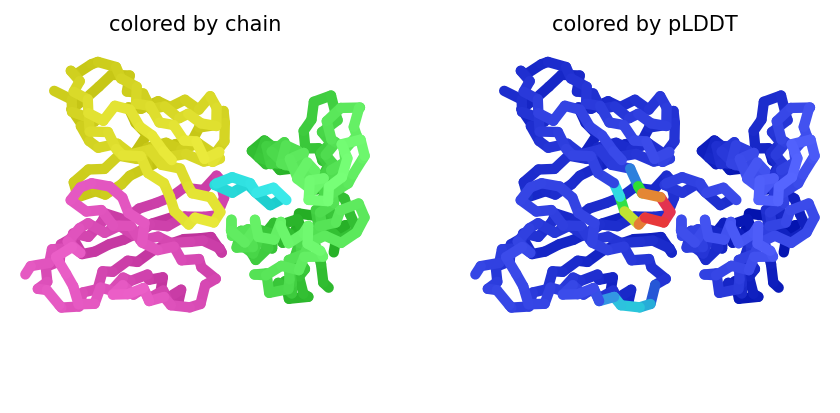

2025-02-12 20:25:46,112 alphafold2_multimer_v3_model_3_seed_002 recycle=0 pLDDT=94.4 pTM=0.877 ipTM=0.843
2025-02-12 20:25:51,314 alphafold2_multimer_v3_model_3_seed_002 recycle=1 pLDDT=95.8 pTM=0.907 ipTM=0.883 tol=0.913
2025-02-12 20:25:56,586 alphafold2_multimer_v3_model_3_seed_002 recycle=2 pLDDT=96.4 pTM=0.932 ipTM=0.912 tol=0.252
2025-02-12 20:25:56,587 alphafold2_multimer_v3_model_3_seed_002 took 15.6s (2 recycles)


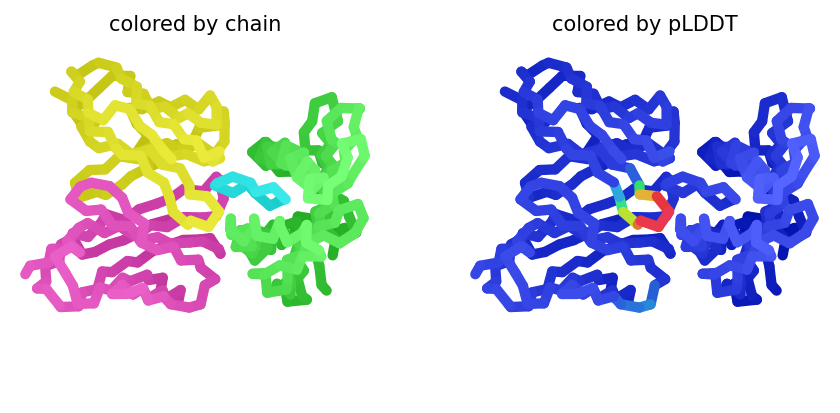

2025-02-12 20:26:02,040 alphafold2_multimer_v3_model_4_seed_002 recycle=0 pLDDT=91.6 pTM=0.703 ipTM=0.603
2025-02-12 20:26:07,310 alphafold2_multimer_v3_model_4_seed_002 recycle=1 pLDDT=96.6 pTM=0.929 ipTM=0.91 tol=1.15
2025-02-12 20:26:12,592 alphafold2_multimer_v3_model_4_seed_002 recycle=2 pLDDT=96.5 pTM=0.934 ipTM=0.91 tol=0.343
2025-02-12 20:26:12,593 alphafold2_multimer_v3_model_4_seed_002 took 15.7s (2 recycles)


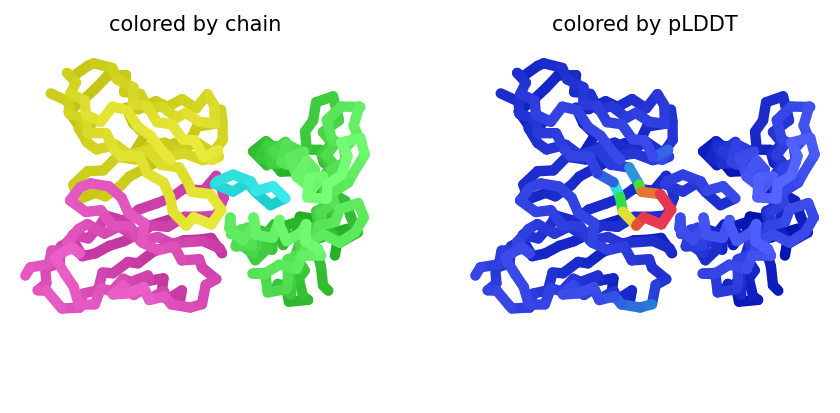

2025-02-12 20:26:18,065 alphafold2_multimer_v3_model_5_seed_002 recycle=0 pLDDT=94.4 pTM=0.837 ipTM=0.786
2025-02-12 20:26:23,268 alphafold2_multimer_v3_model_5_seed_002 recycle=1 pLDDT=96.5 pTM=0.917 ipTM=0.896 tol=1.37
2025-02-12 20:26:28,560 alphafold2_multimer_v3_model_5_seed_002 recycle=2 pLDDT=96.7 pTM=0.939 ipTM=0.919 tol=0.387
2025-02-12 20:26:28,562 alphafold2_multimer_v3_model_5_seed_002 took 15.6s (2 recycles)


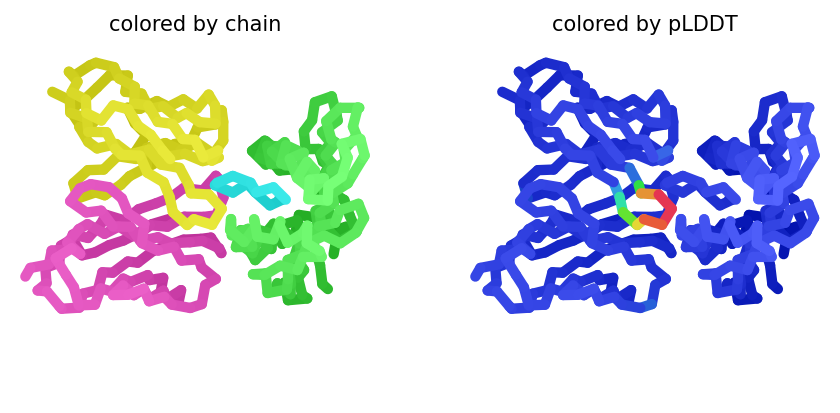

2025-02-12 20:26:34,062 alphafold2_multimer_v3_model_1_seed_003 recycle=0 pLDDT=94.1 pTM=0.829 ipTM=0.772
2025-02-12 20:26:39,214 alphafold2_multimer_v3_model_1_seed_003 recycle=1 pLDDT=95.6 pTM=0.883 ipTM=0.851 tol=1.74
2025-02-12 20:26:44,490 alphafold2_multimer_v3_model_1_seed_003 recycle=2 pLDDT=96.4 pTM=0.931 ipTM=0.913 tol=0.638
2025-02-12 20:26:49,814 alphafold2_multimer_v3_model_1_seed_003 recycle=3 pLDDT=96.6 pTM=0.945 ipTM=0.929 tol=0.371
2025-02-12 20:26:49,815 alphafold2_multimer_v3_model_1_seed_003 took 20.9s (3 recycles)


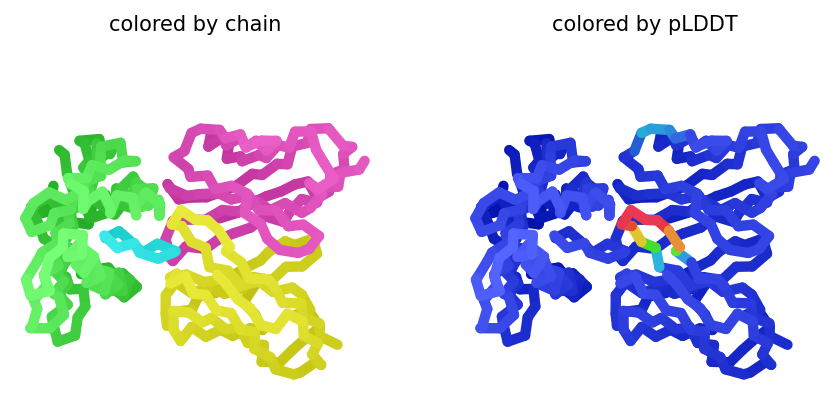

2025-02-12 20:26:55,269 alphafold2_multimer_v3_model_2_seed_003 recycle=0 pLDDT=92 pTM=0.754 ipTM=0.674
2025-02-12 20:27:00,479 alphafold2_multimer_v3_model_2_seed_003 recycle=1 pLDDT=96 pTM=0.908 ipTM=0.885 tol=1.69
2025-02-12 20:27:05,751 alphafold2_multimer_v3_model_2_seed_003 recycle=2 pLDDT=96.4 pTM=0.935 ipTM=0.915 tol=0.344
2025-02-12 20:27:05,752 alphafold2_multimer_v3_model_2_seed_003 took 15.6s (2 recycles)


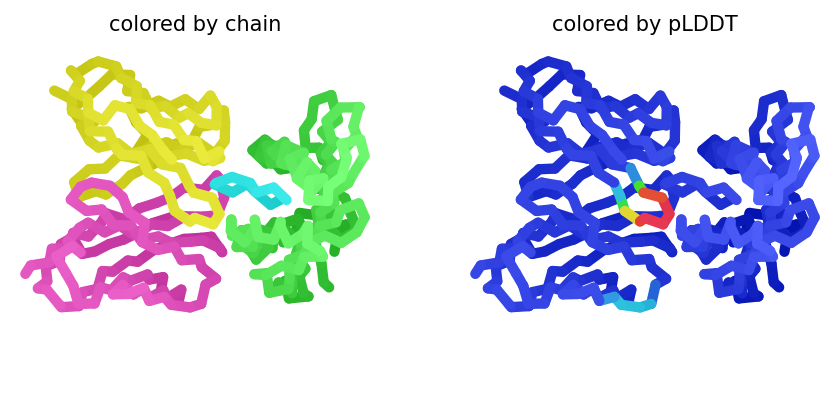

2025-02-12 20:27:11,250 alphafold2_multimer_v3_model_3_seed_003 recycle=0 pLDDT=94.7 pTM=0.878 ipTM=0.844
2025-02-12 20:27:16,408 alphafold2_multimer_v3_model_3_seed_003 recycle=1 pLDDT=95.3 pTM=0.88 ipTM=0.853 tol=1.32
2025-02-12 20:27:21,658 alphafold2_multimer_v3_model_3_seed_003 recycle=2 pLDDT=96.3 pTM=0.926 ipTM=0.909 tol=0.452
2025-02-12 20:27:21,659 alphafold2_multimer_v3_model_3_seed_003 took 15.6s (2 recycles)


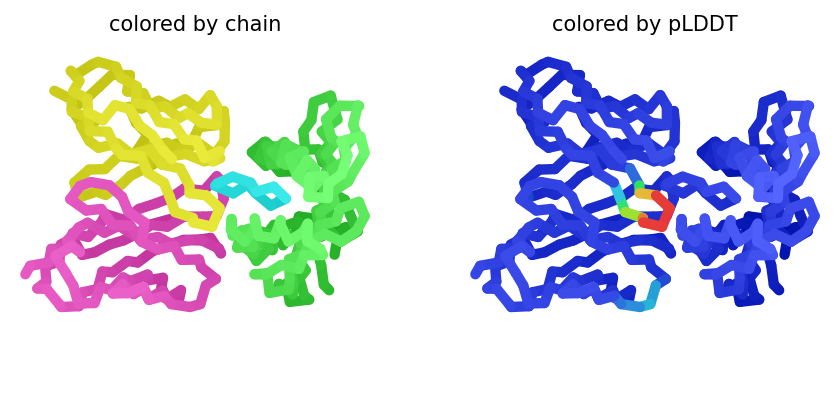

2025-02-12 20:27:27,190 alphafold2_multimer_v3_model_4_seed_003 recycle=0 pLDDT=95.6 pTM=0.892 ipTM=0.864
2025-02-12 20:27:32,304 alphafold2_multimer_v3_model_4_seed_003 recycle=1 pLDDT=95.2 pTM=0.855 ipTM=0.812 tol=1.53
2025-02-12 20:27:37,546 alphafold2_multimer_v3_model_4_seed_003 recycle=2 pLDDT=96.3 pTM=0.926 ipTM=0.907 tol=0.684
2025-02-12 20:27:42,842 alphafold2_multimer_v3_model_4_seed_003 recycle=3 pLDDT=96.6 pTM=0.939 ipTM=0.918 tol=0.137
2025-02-12 20:27:42,843 alphafold2_multimer_v3_model_4_seed_003 took 20.8s (3 recycles)


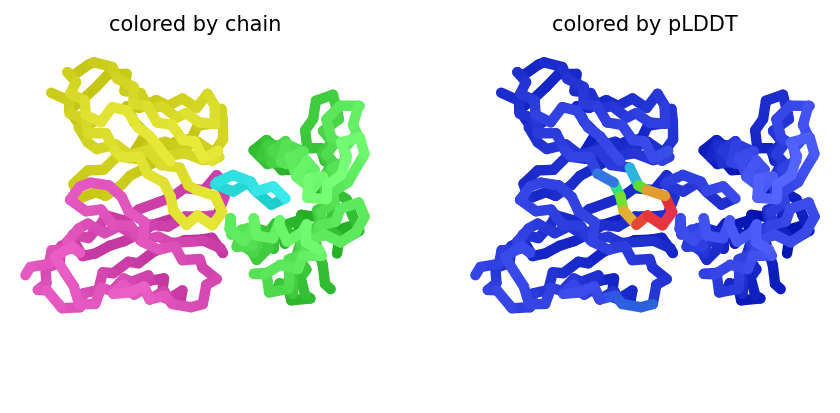

2025-02-12 20:27:48,326 alphafold2_multimer_v3_model_5_seed_003 recycle=0 pLDDT=93.9 pTM=0.827 ipTM=0.773
2025-02-12 20:27:53,559 alphafold2_multimer_v3_model_5_seed_003 recycle=1 pLDDT=96.3 pTM=0.921 ipTM=0.901 tol=0.902
2025-02-12 20:27:58,852 alphafold2_multimer_v3_model_5_seed_003 recycle=2 pLDDT=96.6 pTM=0.94 ipTM=0.919 tol=0.29
2025-02-12 20:27:58,854 alphafold2_multimer_v3_model_5_seed_003 took 15.6s (2 recycles)


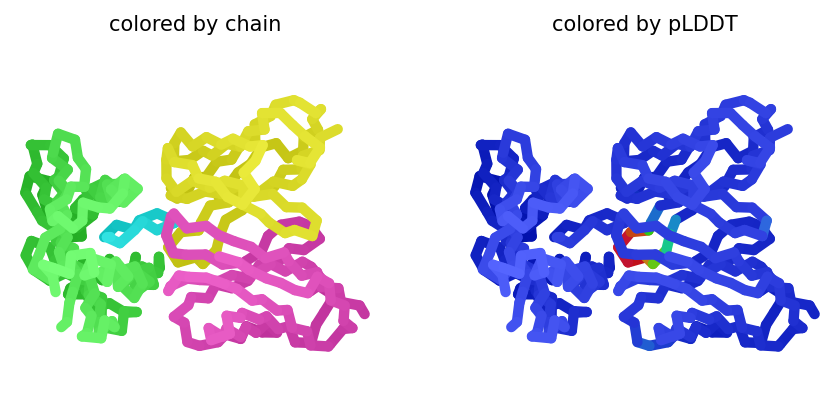

2025-02-12 20:27:59,217 reranking models by 'multimer' metric
2025-02-12 20:28:16,620 Relaxation took 17.4s
2025-02-12 20:28:16,620 rank_001_alphafold2_multimer_v3_model_1_seed_003 pLDDT=96.6 pTM=0.945 ipTM=0.929
2025-02-12 20:28:16,621 rank_002_alphafold2_multimer_v3_model_1_seed_002 pLDDT=96.6 pTM=0.943 ipTM=0.928
2025-02-12 20:28:16,621 rank_003_alphafold2_multimer_v3_model_1_seed_001 pLDDT=96.8 pTM=0.944 ipTM=0.927
2025-02-12 20:28:16,622 rank_004_alphafold2_multimer_v3_model_1_seed_000 pLDDT=96.6 pTM=0.942 ipTM=0.927
2025-02-12 20:28:16,622 rank_005_alphafold2_multimer_v3_model_5_seed_000 pLDDT=96.8 pTM=0.942 ipTM=0.922
2025-02-12 20:28:16,623 rank_006_alphafold2_multimer_v3_model_5_seed_001 pLDDT=96.8 pTM=0.942 ipTM=0.922
2025-02-12 20:28:16,623 rank_007_alphafold2_multimer_v3_model_2_seed_002 pLDDT=96.7 pTM=0.941 ipTM=0.921
2025-02-12 20:28:16,624 rank_008_alphafold2_multimer_v3_model_5_seed_003 pLDDT=96.6 pTM=0.94 ipTM=0.919
2025-02-12 20:28:16,624 rank_009_alphafold2_multimer_

0

In [13]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2
queries_path = "batch_results/batch_queries.csv"
if template_mode == "pdb100":
    use_templates = True
    custom_template_path = None
elif template_mode == "custom":
    custom_template_path = os.path.join(jobname, "template")
    os.makedirs(custom_template_path, exist_ok=True)
    uploaded = files.upload()
    use_templates = True
    for fn in uploaded.keys():
        os.rename(fn, os.path.join(custom_template_path, fn))
else:
    custom_template_path = None
    use_templates = False
# Ensure num_relax is an integer
num_relax = int(num_relax)  # ✅ Fix the type error
import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=calc_extra_ptm,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

In [17]:

# Look for the best-ranked model (rank_001)
pdb_files = glob.glob(f"{jobname}/*rank_001*.pdb")

# Ensure a file is found
if not pdb_files:
    raise FileNotFoundError(f"No PDB file found for rank_001 in {jobname}")

# Load the best model
pdb_file = pdb_files[0]

In [18]:
pdb_file

'TCR_pMHC_batch_1_416b8/TCR_pMHC_batch_0_5600c_unrelaxed_rank_001_alphafold2_multimer_v3_model_4_seed_002.pdb'

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

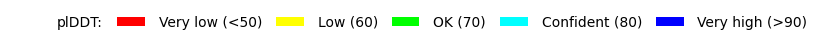

In [21]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = True #@param {type:"boolean"}
show_mainchains = True #@param {type:"boolean"}

'''
tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)
'''
pdb_file = ['TCR_pMHC_batch_1_416b8/TCR_pMHC_batch_0_5600c_unrelaxed_rank_001_alphafold2_multimer_v3_model_4_seed_002.pdb']


def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()


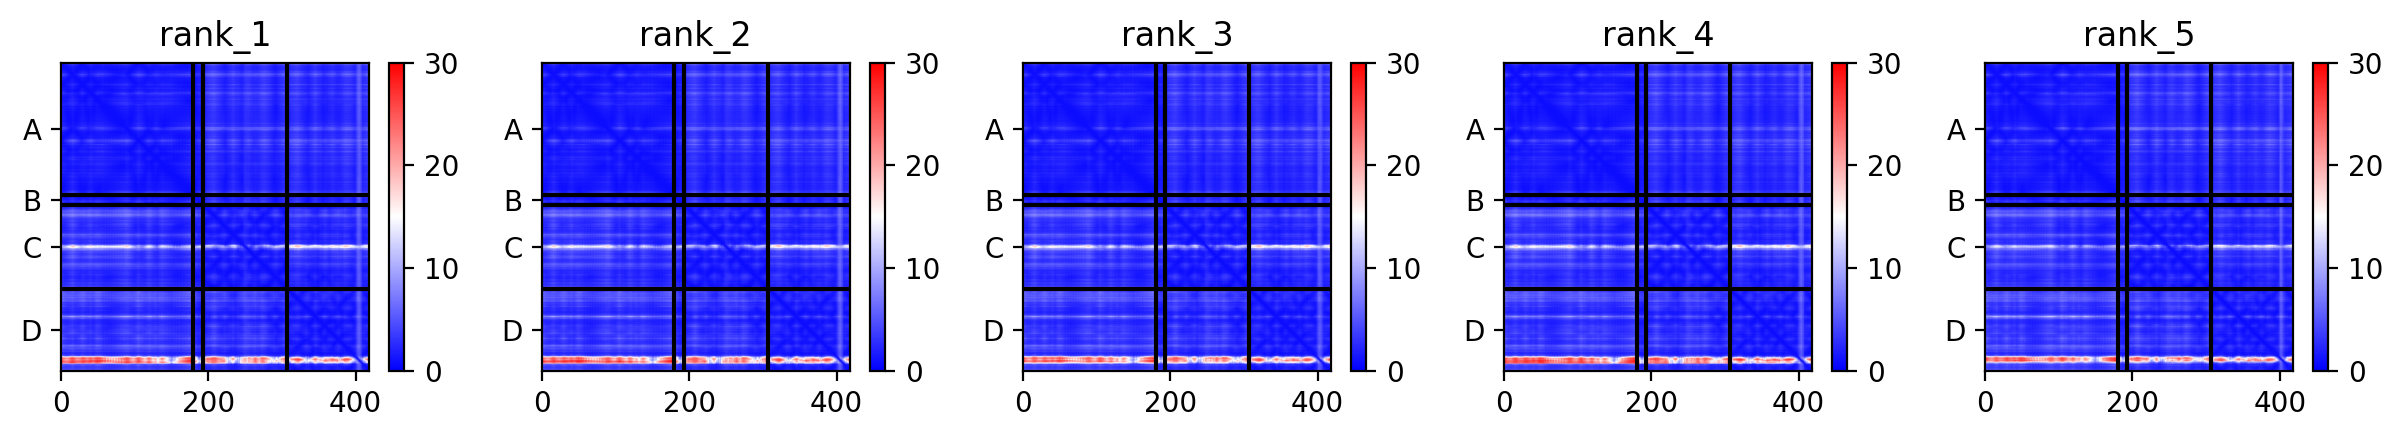
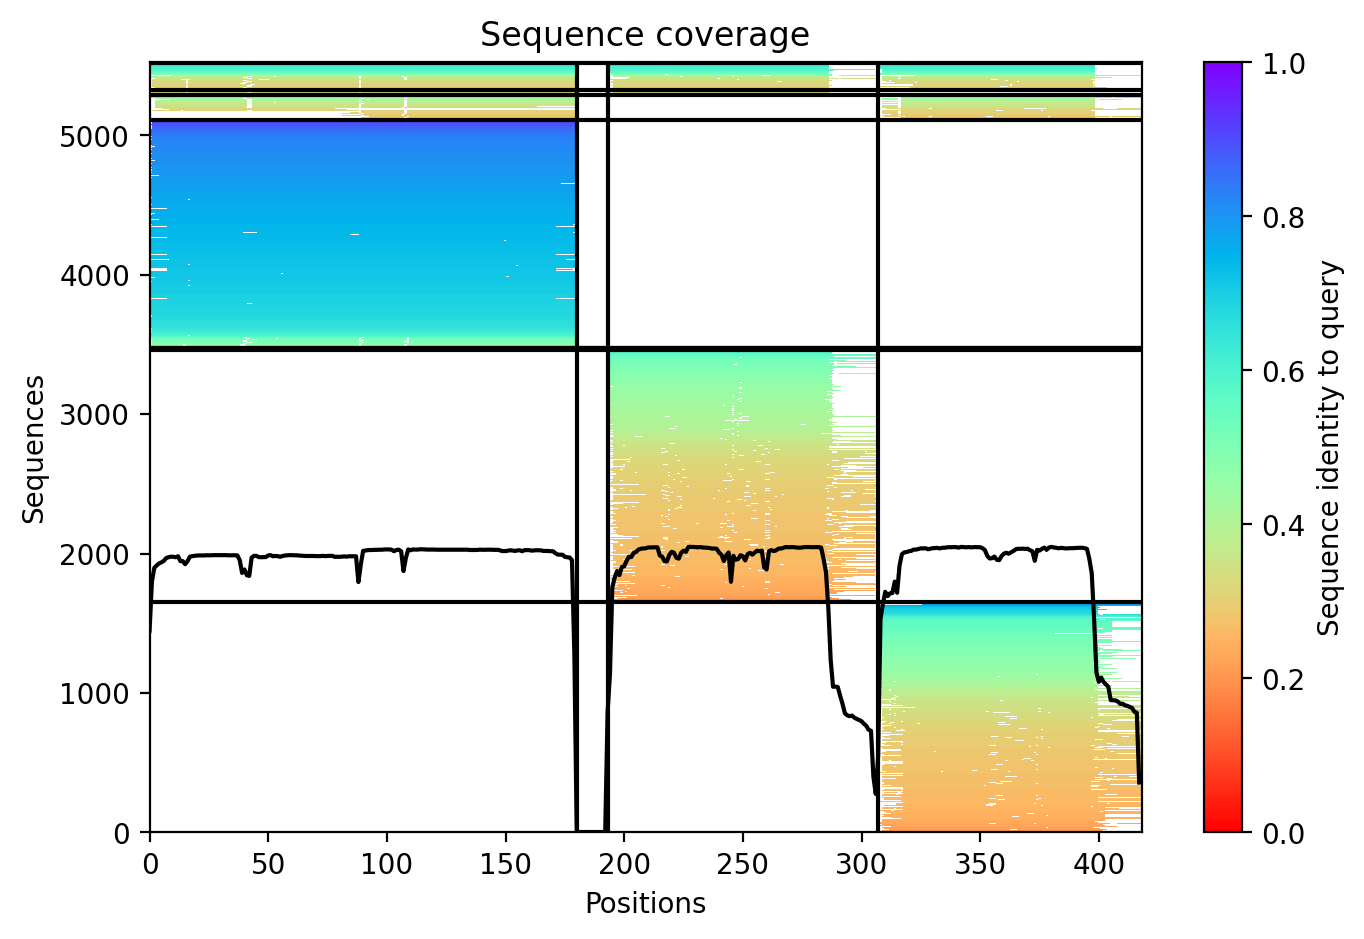
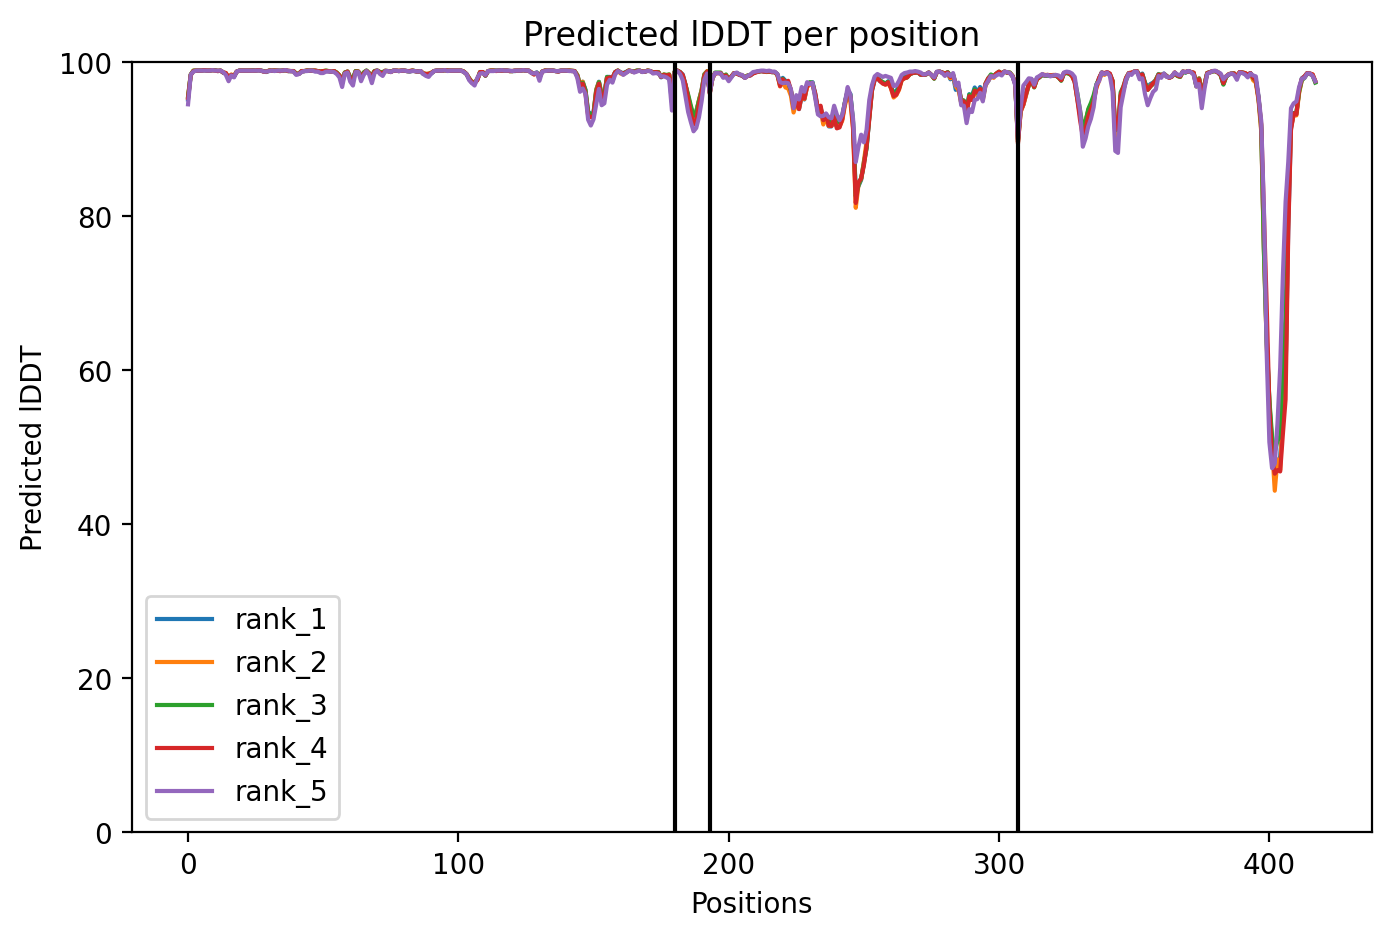

In [22]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = ""
pae_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png")
if os.path.isfile(pae_file):
    pae = image_to_data_url(pae_file)
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  { '<!--' if pae == '' else '' }<img src="{pae}" class="full" />{ '-->' if pae == '' else '' }
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))

In [23]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Uploaded TCR_pMHC_batch_1_416b8.result.zip to Google Drive with ID 1XlUUJrI-kU-2LO4wyVD1IQ24gFMMZEjL


# Instructions <a name="Instructions"></a>
For detailed instructions, tips and tricks, see recently published paper at [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5)

**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.

**Result zip file contents**

1. PDB formatted structures sorted by avg. pLDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. A `predicted_aligned_error_v1.json` using [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) and a `scores.json` for each model which contains an array (list of lists) for PAE, a list with the average pLDDT and the pTMscore.
7. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

**MSA generation for complexes**

For the complex prediction we use unpaired and paired MSAs. Unpaired MSA is generated the same way as for the protein structures prediction by searching the UniRef100 and environmental sequences three iterations each.

The paired MSA is generated by searching the UniRef100 database and pairing the best hits sharing the same NCBI taxonomic identifier (=species or sub-species). We only pair sequences if all of the query sequences are present for the respective taxonomic identifier.

**Using a custom MSA as input**

To predict the structure with a custom MSA (A3M formatted): (1) Change the `msa_mode`: to "custom", (2) Wait for an upload box to appear at the end of the "MSA options ..." box. Upload your A3M. The first fasta entry of the A3M must be the query sequence without gaps.

It is also possilbe to proide custom MSAs for complex predictions. Read more about the format [here](https://github.com/sokrypton/ColabFold/issues/76).

As an alternative for MSA generation the [HHblits Toolkit server](https://toolkit.tuebingen.mpg.de/tools/hhblits) can be used. After submitting your query, click "Query Template MSA" -> "Download Full A3M". Download the A3M file and upload it in this notebook.

**PDB100** <a name="pdb100"></a>

As of 23/06/08, we have transitioned from using the PDB70 to a 100% clustered PDB, the PDB100. The construction methodology of PDB100 differs from that of PDB70.

The PDB70 was constructed by running each PDB70 representative sequence through [HHblits](https://github.com/soedinglab/hh-suite) against the [Uniclust30](https://uniclust.mmseqs.com/). On the other hand, the PDB100 is built by searching each PDB100 representative structure with [Foldseek](https://github.com/steineggerlab/foldseek) against the [AlphaFold Database](https://alphafold.ebi.ac.uk).

To maintain compatibility with older Notebook versions and local installations, the generated files and API responses will continue to be named "PDB70", even though we're now using the PDB100.

**Using custom templates** <a name="custom_templates"></a>

To predict the structure with a custom template (PDB or mmCIF formatted): (1) change the `template_mode` to "custom" in the execute cell and (2) wait for an upload box to appear at the end of the "Input Protein" box. Select and upload your templates (multiple choices are possible).

* Templates must follow the four letter PDB naming with lower case letters.

* Templates in mmCIF format must contain `_entity_poly_seq`. An error is thrown if this field is not present. The field `_pdbx_audit_revision_history.revision_date` is automatically generated if it is not present.

* Templates in PDB format are automatically converted to the mmCIF format. `_entity_poly_seq` and `_pdbx_audit_revision_history.revision_date` are automatically generated.

If you encounter problems, please report them to this [issue](https://github.com/sokrypton/ColabFold/issues/177).

**Comparison to the full AlphaFold2 and AlphaFold2 Colab**

This notebook replaces the homology detection and MSA pairing of AlphaFold2 with MMseqs2. For a comparison against the [AlphaFold2 Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) and the full [AlphaFold2](https://github.com/deepmind/alphafold) system read our [paper](https://www.nature.com/articles/s41592-022-01488-1).

**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or MGnify.
* We recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues

**License**

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software.

- [KOBIC](https://kobic.re.kr) and [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server.

- Richard Evans for helping to benchmark the ColabFold's Alphafold-multimer support.

- [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!

- Do-Yoon Kim for creating the ColabFold logo.

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).
